In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, ElasticNet
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

import optuna

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
pd.set_option('display.float_format', '{:.1f}'.format)

# Import df

In [5]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')

## Data preprocess classes

In [6]:
class dfCleaner(BaseEstimator, TransformerMixin):
    """
    Custom transformer to clean podcast listening dataset:
    - Caps extreme ad counts.
    - Adjusts episode lengths.
    - Fixes percentages > 100.
    - Ensures logical consistency between listening time and episode length.
    - Fills missing values using group means by Podcast_Name and Episode_Title.
    """
    
    def __init__(self):
        self.feature_names_ = None
    
    def fit(self, X, y=None):
        """No fitting required."""
        return self

    def transform(self, X):
        X = X.copy()

        # outlier filtering
        numeric_cols = X.select_dtypes(include='number').columns
        thresholds = X[numeric_cols].quantile(0.99)
        no_nans = X[numeric_cols].notna().all(axis=1)
        within_thresholds = (X[numeric_cols] <= thresholds).all(axis=1)
        df_filtered = X[no_nans & within_thresholds].copy()


        # find group (nooutlier) means
        group_cols = ['Podcast_Name', 'Publication_Time', 'Genre']
        group_means = df_filtered.groupby(group_cols)[numeric_cols].mean().reset_index()
        group_means = group_means.rename(columns={col: f"{col}_mean" for col in numeric_cols})
        X = X.merge(group_means, how='left', on=group_cols)
        
        # Fill with group mean first, then global mean as fallback
        for col in numeric_cols:
            mean_col = f"{col}_mean"
            X[col] = X[col].fillna(X[mean_col])
            X[col] = X[col].fillna(X[col].mean())  # fallback to overall mean
        
        X.drop(columns=[f"{col}_mean" for col in numeric_cols], inplace=True)
        
        # Cap Number_of_Ads
        if 'Number_of_Ads' in X.columns:
            X.loc[X['Number_of_Ads'] > 3, 'Number_of_Ads'] = 1
    
        # Adjust Episode_Length_minutes > 121
        if 'Episode_Length_minutes' in X.columns:
            ep_group = ['Genre', 'Podcast_Name']
            if all(col in X.columns for col in ep_group):
                # Create a group mean DataFrame
                ep_means_df = (
                    df_filtered.groupby(ep_group)['Episode_Length_minutes']
                    .mean()
                    .reset_index()
                    .rename(columns={'Episode_Length_minutes': 'Episode_Length_mean'})
                )
        
                # Merge the means into X
                X = X.merge(ep_means_df, how='left', on=ep_group)
        
                # Replace long episode lengths with group mean
                mask = X['Episode_Length_minutes'] > 121
                X.loc[mask, 'Episode_Length_minutes'] = X.loc[mask, 'Episode_Length_mean']
                X.loc[mask, 'Episode_Length_minutes'] = X['Episode_Length_minutes'].fillna(X['Episode_Length_minutes'].mean())
        
                # Drop the temp column
                X.drop(columns='Episode_Length_mean', inplace=True)
            
        # Fix popularity percentage > 100
        for col in ['Host_Popularity_percentage', 'Guest_Popularity_percentage']:
            if col in X.columns:
                mask = X[col] > 100
                if mask.any():
                    X.loc[mask, col] = X.loc[~mask, col].mean()
    
        if 'id' in X.columns:
            X = X.set_index('id')

        self.feature_names_ = X.columns
           
        return X

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_ is None:
            raise ValueError("You must call fit or fit_transform before getting feature names.")
        return self.feature_names_


In [7]:
class SmartCategoricalEncoder(BaseEstimator, TransformerMixin):
    """
    Transformer for handling categorical features using:
    - One-Hot Encoding for low-cardinality (<11)
    - Frequency Encoding for high-cardinality (>70)
    - Target Encoding for intermediate cardinality (11 to 70)
    """
    def __init__(self, target_name=None, smooth_factor=1):
        self.target_name = target_name
        self.smooth_factor = smooth_factor
        self.encoders = {}  
        self.freq_maps = {}
        self.one_hot_encoders = {}
        self.feature_names_ = None 

    def fit(self, X, y=None):
        X = X.copy()
        if self.target_name is None and y is None:
            raise ValueError("Either 'target_name' or 'y' must be provided for target encoding.")

        if y is None:
            y = X[self.target_name]

        cat_df = X.select_dtypes(include=['object', 'category'])

        for col in cat_df.columns:
            nunique = cat_df[col].nunique()

            if nunique < 11:
                encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
                encoder.fit(cat_df[[col]])
                self.one_hot_encoders[col] = encoder

            elif nunique > 70:
                freq_map = cat_df[col].value_counts().to_dict()
                self.freq_maps[col] = freq_map

            else:
                target_encoder = TargetEncoder(cols=[col], smoothing=self.smooth_factor)
                target_encoder.fit(cat_df[[col]], y)
                self.encoders[col] = target_encoder

        return self

    def transform(self, X):
        X = X.copy()
        final_df = pd.DataFrame(index=X.index)
        cat_df = X.select_dtypes(include=['object', 'category'])

        for col in cat_df.columns:
            if col in self.one_hot_encoders:
                encoder = self.one_hot_encoders[col]
                encoded_array = encoder.transform(cat_df[[col]])
                encoded_cols = encoder.get_feature_names_out([col])
                encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=cat_df.index)
                final_df = final_df.join(encoded_df)

            elif col in self.freq_maps:
                freq_map = self.freq_maps[col]
                final_df[col + '_freq'] = cat_df[col].map(freq_map)

            elif col in self.encoders:
                encoder = self.encoders[col]
                encoded_df = encoder.transform(cat_df[[col]])
                final_df = final_df.join(encoded_df)

        # Preserve numeric columns except the target
        numeric_df = X.select_dtypes(include=['int', 'float']).drop(columns=[self.target_name], errors='ignore')
        final_df = final_df.join(numeric_df)

        # Save feature names
        self.feature_names_ = final_df.columns.tolist()

        return final_df

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_ is None:
            raise ValueError("You must call fit or fit_transform before getting feature names.")
        return self.feature_names_


In [8]:
class AddClusterLabels(BaseEstimator, TransformerMixin):
    """
    Adds KMeans cluster labels to the dataset using One-Hot Encoding.
    - Automatically handles DataFrame or NumPy array inputs.
    - One-hot encoded cluster labels are appended to the original features.
    """
    def __init__(self, n_clusters=10, one_hot=True, drop_first=True):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
        self.one_hot = one_hot
        self.drop_first = drop_first
        self.encoder = None
        self.feature_names_in_ = None
        self.feature_names_ = None

    def fit(self, X, y=None):
        self.kmeans.fit(X)
        labels = self.kmeans.labels_.reshape(-1, 1)

        if self.one_hot:
            self.encoder = OneHotEncoder(sparse=False, drop='first' if self.drop_first else None)
            self.encoder.fit(labels)

        # extract feature names from the previous step in the pipeline
        if hasattr(self, 'previous_step') and hasattr(self.previous_step, 'get_feature_names_out'):
            self.feature_names_in_ = self.previous_step.get_feature_names_out()
        else:
            # If no previous step or no feature names from previous step, fallback to default
            self.feature_names_in_ = [f'feature_{i}' for i in range(X.shape[1])]

        # Generate cluster feature names
        if self.one_hot:
            cluster_names = self.encoder.get_feature_names_out(['cluster'])
        else:
            cluster_names = [f'cluster_label']

        self.feature_names_ = self.feature_names_in_ + list(cluster_names)

        return self

    def transform(self, X):
        labels = self.kmeans.predict(X).reshape(-1, 1)
        if self.one_hot:
            cluster_features = self.encoder.transform(labels)
        else:
            cluster_features = labels  # Keep single column

        return np.hstack([X, cluster_features])

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_  # fallback to original feature names

        # Generate final feature names
        cluster_names = (
            self.encoder.get_feature_names_out(['cluster']) if self.one_hot
            else [f'cluster_label']
        )
        
        return list(input_features) + list(cluster_names)

In [9]:
class AddPrincipalComponents(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def fit(self, X, y=None):
        self.pca.fit(X)
        return self

    def transform(self, X):
        # Apply PCA and append the components as new columns
        pca_components = self.pca.transform(X)
        return np.hstack([X, pca_components])

In [10]:
def objective(trial, X_train, y_train, params, model):
    try:
        model = model(**params)
        kfold = KFold(n_splits=3, shuffle=True, random_state=42)  

        rmse_scores = cross_val_score(
            model, X_train, y_train, 
            cv=kfold, 
            scoring='neg_root_mean_squared_error'
        )
        mean_rmse = -rmse_scores.mean()
        return mean_rmse

    except Exception as e:
        print(f"Trial failed with error: {e}")
        raise TrialPruned()

## Preprocess pipelines

In [11]:
numeric_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage',
'Number_of_Ads', 'Podcast_Name', 'Episode_Title_freq'] 

scale_numeric = ColumnTransformer(transformers=[('scale_num', StandardScaler(), numeric_cols)],
                                  remainder='passthrough')

In [12]:
preprocess_base =  Pipeline(steps=[('cleaner', dfCleaner()),
                                   ('category_transform', SmartCategoricalEncoder(target_name='Listening_Time_minutes', smooth_factor=5)),
                                   ('scale_numeric', scale_numeric)
                                  ])

In [13]:
preprocess_to_PCA =  Pipeline(steps=[('cleaner', dfCleaner()),
                                     ('category_transform', SmartCategoricalEncoder(target_name='Listening_Time_minutes', smooth_factor=5)),
                                     ('scale_numeric', scale_numeric),
                                     ('pca', PCA(n_components=25)),
                                     ])

In [14]:
preprocess_with_clusters =  Pipeline(steps=[('cleaner', dfCleaner()),
                                     ('category_transform', SmartCategoricalEncoder(target_name='Listening_Time_minutes', smooth_factor=5)),
                                     ('scale_numeric', scale_numeric),
                                     ('cluster', AddClusterLabels(n_clusters=10, one_hot=True, drop_first=True)),
                                     ])

## Define optimal clusters number

In [15]:
# df_transformed = preprocess_base.fit_transform(train_df)
# column_names = preprocess_base.get_feature_names_out() 
# clear_col = [col.replace('scale_num__', 'scaled_').replace('remainder__', '') for col in column_names]
# df_transformed = pd.DataFrame(data = df_transformed, columns = clear_col)
# df_transformed.head(5)


In [16]:
# Elbow Method
# wcss = []  # Within-cluster sum of squares
# K_range = range(1, 15)

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
#     kmeans.fit(df_transformed)
#     wcss.append(kmeans.inertia_)

# # 4. Plot the Elbow
# plt.figure(figsize=(8, 4))
# plt.plot(K_range, wcss, 'bo-')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('WCSS')
# plt.title('Elbow Method for Optimal k')
# plt.grid(True)
# plt.show()

## Define number of PC (PCA)

In [17]:

# n_comp = 25

# pca = PCA(n_components=n_comp)
# pr_comp = pca.fit_transform(df_transformed)

# pca_df = pd.DataFrame(data= pr_comp, columns=[f'pca_{i}' for i in range(n_comp)])
        
        
# exp_var = pca.explained_variance_ratio_
# cum_var = np.cumsum(exp_var)

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(exp_var)+1), exp_var, marker='o', label='Individual Explained Variance')
# plt.plot(range(1, len(cum_var)+1), cum_var, marker='s', label='Cumulative Explained Variance', color='green')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('Explained Variance by PCA Components')
# plt.legend()
# plt.grid(True)
# plt.show()

In [18]:
# for i, (var, cum) in enumerate(zip(exp_var, cum_var), 1):
#     print(f"PC{i}: {var:.4f}  |  Cumulative: {cum:.2f}")

## Train/valid splits

In [19]:
# Turn features to PC

df_PCA = pd.DataFrame(preprocess_to_PCA.fit_transform(train_df), 
                         columns=preprocess_to_PCA.get_feature_names_out(),  
                         index=train_df.index)

In [20]:
# Turn features to scaled version and add clusters

df_clusters = pd.DataFrame(preprocess_with_clusters.fit_transform(train_df), 
                          columns=preprocess_with_clusters.get_feature_names_out(),  
                          index=train_df.index)  

In [21]:
# Train/test split 

train_idx, test_idx = train_test_split(df_PCA.index, test_size=0.1, random_state=42)

In [22]:
# for PCA df
X_train_pc, X_valid_pc = df_PCA.loc[train_idx], df_PCA.loc[test_idx]
y_train_pc, y_valid_pc = train_df['Listening_Time_minutes'].loc[train_idx], train_df['Listening_Time_minutes'].loc[test_idx]

In [23]:
# for clustered df
X_train_c, X_valid_c = df_clusters.loc[train_idx], df_clusters.loc[test_idx]
y_train_c, y_valid_c = train_df['Listening_Time_minutes'].loc[train_idx], train_df['Listening_Time_minutes'].loc[test_idx]

In [24]:
test_data_PCA = pd.DataFrame(preprocess_to_PCA.transform(test_df), 
                             columns=preprocess_to_PCA.get_feature_names_out(),  
                             index=test_df.index) 

test_data_clusters = pd.DataFrame(preprocess_with_clusters.transform(test_df), 
                                  columns=preprocess_with_clusters.get_feature_names_out(),  
                                  index=test_df.index) 

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


## Elastic Net (en)

In [25]:
# find best params for model

# def define_EN_params(trial: object) -> object:
#         params = {
#         'alpha': trial.suggest_loguniform('alpha', 1e-6, 1e+1),
#         'l1_ratio': trial.suggest_uniform('l1_ratio', 0.0, 1.0),
#         'random_state': 42
#         }
#         return params

In [26]:
# study_EN = optuna.create_study(direction='minimize')
    
# # # Define the objective function inline, using the current dataset version
# study_EN.optimize(lambda trial: objective(trial, 
#                                            X_train=X_train,
#                                            y_train=y_train,
#                                            params=define_EN_params(trial),
#                                            model=ElasticNet
#                                            ),
#                                  n_trials=100
                  # )

In [27]:
# best_EN_param = study_EN.best_trial.params

best_EN_param_for_pca = {'alpha': 2.3040401194364588e-05, 'l1_ratio': 0.02101612974703571}
best_EN_param_for_df_with_clusters = {'alpha': 0.005253015057271132, 'l1_ratio': 0.9965909461616541}


In [28]:
# fit model
model = ElasticNet(**best_EN_param_for_pca)
en_model = model.fit(X_train_pc, y_train_pc)

# train test predictions
train_en_predict = en_model.predict(X_train_pc)
test_en_predict = en_model.predict(X_valid_pc)

print(f'rmse for valid - {np.sqrt(mean_squared_error(y_valid_pc, test_en_predict))}')

# rmse for pca - 13.2939
# rmse for scaled with clusters - 13.35398

rmse for valid - 13.310088540267161


In [29]:
# residuals count

train_en_resid = y_train_pc - train_en_predict
test_en_resid = y_valid_pc - test_en_predict

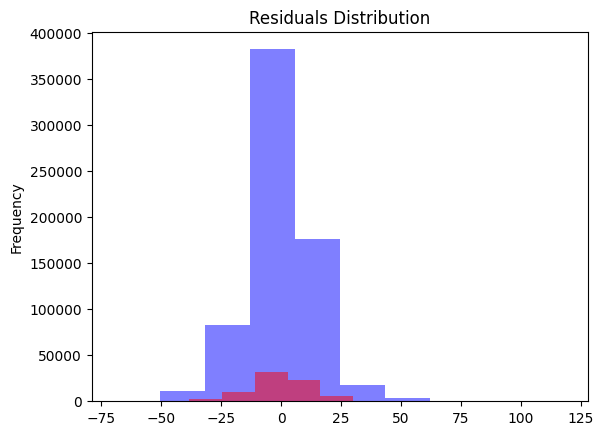

In [30]:
train_en_resid.plot(kind='hist', alpha=0.5, color='blue', label='Train Residuals')
test_en_resid.plot(kind='hist', alpha=0.5, color='red', label='Test Residuals')
plt.title('Residuals Distribution')
plt.show()

In [31]:
# coef_df = pd.DataFrame({
#     'Feature': [f'pca_{i}' for i in range(25)],
#     'Coefficient': en_model.coef_
# })
# coef_df.sort_values('Coefficient', ascending=True)

In [32]:
# kfold = KFold(n_splits=3, shuffle=True, random_state=42)  
# rmse_scores = cross_val_score(en_model, df, train_df['Listening_Time_minutes'], cv=kfold, scoring='neg_root_mean_squared_error')
# mean_rmse = -rmse_scores.mean()
# mean_rmse

In [33]:
# final_en_prediction = en_model.predict(test_data_PCA)

In [34]:
# submission_df = pd.DataFrame(index=test_df.id, columns=['Listening_Time_minutes'], data = final_en_prediction)
# submission_df.to_csv('submission.csv')

## XGBOOST residuals prediction

In [35]:
def define_XGB_params(trial: object) -> object:
        params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'random_state': 42
        }
        return params

In [36]:
# study_XGB = optuna.create_study(direction='minimize')
    
# # Define the objective function inline, using the current dataset version
# study_XGB.optimize(lambda trial: objective(trial, 
#                                            X_train=X_train_c,
#                                            y_train=train_en_resid,
#                                            params=define_XGB_params(trial),
#                                            model=XGBRegressor
#                                            ),
#                                  n_trials=50
#                   )

In [37]:
# best_XGB_params = study_XGB.best_trial.params

In [38]:
best_XGB_params_for_PC =  {'n_estimators': 180, 
                           'max_depth': 13, 
                           'learning_rate': 0.031294078471867944, 
                           'subsample': 0.8961233425857253, 
                           'colsample_bytree': 0.8029783192873106}

best_XGB_for_df_with_clusters = {'n_estimators': 266,
                                 'max_depth': 14,
                                 'learning_rate': 0.0337948950616333,
                                 'subsample': 0.8340874974199307,
                                 'colsample_bytree': 0.7846367146534168}

In [39]:
# # fit model
# XGB_model = XGBRegressor(**best_XGB_for_df_with_clusters)      
# XGB_model.fit(X_train_c, train_en_resid)

# # predict residuals
# train_resid_predict = XGB_model.predict(X_train_c)
# test_resid_predict = XGB_model.predict(X_valid_c)

# #count final prediction
# final_train_predict = train_en_predict + train_resid_predict
# final_test_predict = test_en_predict + test_resid_predict

# #count rmse
# print(f'rmse for train - {np.sqrt(mean_squared_error(y_train_c, final_train_predict))}')
# print(f'rmse for valid - {np.sqrt(mean_squared_error(y_valid_c, final_test_predict))}')

In [40]:
# final_resid_predict = XGB_model.predict(test_data_clusters)
# main_predict = final_en_prediction + final_resid_predict

In [41]:
# submission_df = pd.DataFrame(index=test_df.id, columns=['Listening_Time_minutes'], data = main_predict)
# submission_df.to_csv('submission.csv')

## NN model

In [42]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Add, BatchNormalization, LayerNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

2025-04-26 21:38:07.849341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745703488.358440     837 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745703488.495230     837 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### NN_model_1

In [43]:
## NN model 1
## listen_time prediction

input_layer = Input(shape=(X_train_pc.shape[1],))
x = BatchNormalization()(input_layer)

x = Dense(64)(x)
x = LayerNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

# Residual block
res1 = Dense(64)(x)
res1 = LayerNormalization()(res1)
res1 = Activation('relu')(res1)
res1 = Dropout(0.4)(res1)

x = Add()([x, res1])
x = LayerNormalization()(x)  

# Further layers
x = Dense(128)(x)
x = LayerNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)

output = Dense(1)(x)

# Build the model
model_nn_1 = Model(inputs=input_layer, outputs=output)

# Compile the model
model_nn_1.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Set early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=6, 
                           restore_best_weights=True,
                           min_delta=0.005) 


I0000 00:00:1745703500.673740     837 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745703500.674543     837 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [44]:
# Train the model_nn_1
history = model_nn_1.fit(X_train_pc, y_train_pc, 
                       validation_data=(X_valid_pc, y_valid_pc), 
                       epochs=50, 
                       batch_size=128, 
                       callbacks=[early_stop],
                       verbose=1)

# Predict on test set
y_pred = model_nn_1.predict(X_valid_pc)
rmse = np.sqrt(mean_squared_error(y_valid_pc, y_pred))
print("Test RMSE:", rmse)

Epoch 1/50


I0000 00:00:1745703507.763350     885 service.cc:148] XLA service 0x7f183401a4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745703507.764692     885 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745703507.764717     885 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745703508.387899     885 cuda_dnn.cc:529] Loaded cuDNN version 90300


  85/5274 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2768.6929  

I0000 00:00:1745703511.578496     885 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5274/5274 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1004.2474 - val_loss: 195.4323
Epoch 2/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 244.1698 - val_loss: 187.7517
Epoch 3/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 226.8088 - val_loss: 183.9525
Epoch 4/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 217.0084 - val_loss: 181.9553
Epoch 5/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 211.0559 - val_loss: 179.7997
Epoch 6/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 207.7255 - val_loss: 178.3670
Epoch 7/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 205.2816 - val_loss: 178.0162
Epoch 8/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 202.0026 - val_loss: 177.4621
Epoch 9/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 201.2399 - val_loss: 177.2671
Epoch 10/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 200.4013 - val_loss: 176.6679
Epoch 11/50
5274/5274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 199.0958 - val_

<Axes: >

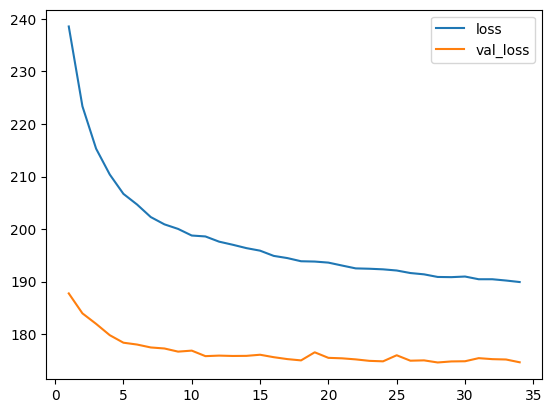

In [45]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()

In [46]:
y_train_predict = model_nn_1.predict(X_train_pc)

21094/21094 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step


In [ ]:
## train residuals 
train_residuals = y_train_pc - y_train_predict

# valid residuals 
valid_residuals =  y_valid_pc - y_pred

In [ ]:
y_train_predict

### NN_model_2 (residuals prediction after model_1)

In [ ]:
## nn model 2 ResNet-style 
## residuals predicion

# Input Layer
input_layer = Input(shape=(X_train_c.shape[1],))
x = BatchNormalization()(input_layer)

# First Dense block
x = Dense(64, kernel_regularizer=regularizers.l2(0.01))(x)
x = LayerNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

# Residual Block 1
res1 = Dense(64, kernel_regularizer=regularizers.l2(0.01))(x)
res1 = LayerNormalization()(res1)
res1 = Activation('relu')(res1)
res1 = Dropout(0.4)(res1)

x = Add()([x, res1])
x = LayerNormalization()(x)  # Normalize after add

# Residual Block 2
res2 = Dense(64, kernel_regularizer=regularizers.l2(0.01))(x)
res2 = LayerNormalization()(res2)
res2 = Activation('relu')(res2)
res2 = Dropout(0.4)(res2)

x = Add()([x, res2])
x = LayerNormalization()(x)

# Residual Block 3
res3 = Dense(64, kernel_regularizer=regularizers.l2(0.01))(x)
res3 = LayerNormalization()(res3)
res3 = Activation('relu')(res3)
res3 = Dropout(0.3)(res3)

x = Add()([x, res3])
x = LayerNormalization()(x)

# Final layers
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

# Output Layer
output = Dense(1)(x)

# Build model
model_nn_2 = Model(inputs=input_layer, outputs=output)

# Compile
model_nn_2.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=6, 
                           restore_best_weights=True,
                           min_delta=0.005)

In [ ]:
history_resid = model_nn_2.fit(X_train_c, train_residuals, 
                       validation_data=(X_valid_c, valid_residuals), 
                       epochs=40, 
                       batch_size=128, 
                       callbacks=[early_stop],
                       verbose=1)

# Predict on test set
resid_pred = model_nn_2.predict(X_valid_c)
rmse = np.sqrt(mean_squared_error(y_valid_c, resid_pred))
print("Test RMSE:", rmse)

In [ ]:
history_resid_df = pd.DataFrame(history_resid.history)
history_resid_df.loc[1:, ['loss', 'val_loss']].plot()

In [ ]:
y_valid_c = y_valid_pc

In [ ]:
final_valid_pred =  y_valid_predict + resid_pred
rmse = np.sqrt(mean_squared_error(y_valid_c, final_valid_pred))
print("Test RMSE:", rmse)

In [ ]:
# predict from clustered test df

predictions_nn2_cluster = model_nn_2.predict(test_data_clusters)
predictions_nn2_cluster

In [ ]:
# submission_df = pd.DataFrame(index=test_df.id, columns=['Listening_Time_minutes'], data = predictions_nn2_cluster)
# submission_df.to_csv('submission.csv')